# Bayesian inference: Part 2: Solutions to Exercises

## VI. Implementing your own MCMC

In [1]:
# As usual, we start with some imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy

### VI.1 Metropolis-Hastings Procedure

Recall the Metropolis-Hastings procedure:

1. Define a posterior $p(\theta~|~D, I)$
2. Define a *proposal density* $p(\theta_{i + 1}~|~\theta_i)$, which must be a symmetric function, but otherwise is unconstrained (a Gaussian is the usual choice).
3. Choose a starting point $\theta_0$
4. Repeat the following:

   1. Given $\theta_i$, draw a new $\theta_{i + 1}$ from the proposal distribution
   
   2. Compute the *acceptance ratio*
      $$
      a = \frac{p(\theta_{i + 1}~|~D,I)}{p(\theta_i~|~D,I)}
      $$
   
   3. If $a \ge 1$, the proposal is more likely: accept the draw and add $\theta_{i + 1}$ to the chain.
   
   4. If $a < 1$, then accept the point with probability $a$: this can be done by drawing a uniform random number $r$ and checking if $a < r$. If the point is accepted, add $\theta_{i + 1}$ to the chain. If not, then add $\theta_i$ to the chain *again*.
   
The goal is to produce a "chain", i.e. a list of $\theta$ values, where each $\theta$ is a vector of parameters for your model.
Here we'll write a simple Metropolis-Hastings sampler in Python.

Note that the ``np.random.randn()`` function will be useful: it returns a pseudorandom value drawn from a standard normal distribution (i.e. mean of zero and variance of 1).

### VI.2 Implementation

The cells below describe the various steps that you will implement by yourself
Estimated time: 45 minutes

*Data:* We'll use data drawn from a straight line model

In [2]:
def make_data(intercept, slope, N=20, dy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(20)
    y = intercept + slope * x
    y += dy * rand.randn(20)
    return x, y, dy * np.ones_like(x)

theta_true = (2, 0.5)
x, y, dy = make_data(*theta_true)

First plot the data to see what we're looking at (Use a ``plt.errorbar()`` plot with the provided data)

<Container object of 3 artists>

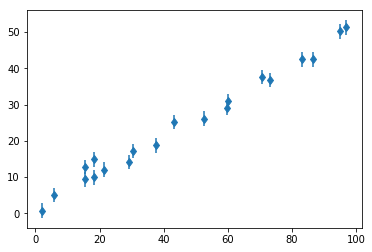

In [3]:
plt.errorbar(x, y, yerr=dy, marker='d', ls='')

Our model will also be a line, as we have done in the previous lecture. 

In [4]:
def model(theta, x):
    # the `theta` argument is a list of parameter values, e.g., theta = [slope, intercept] for a line
    return theta[0]*x + theta[1]

We'll start with the assumption that the data are independent and identically distributed so that the likelihood is simply a product of Gaussians (one big Gaussian). We'll also assume that the uncertainties reported are correct, and that there are no uncertainties on the `x` data. We need to define a function that will evaluate the (ln)likelihood of the data, given a particular choice of your model parameters. A good way to structure this function is as follows:

In [5]:
def ln_likelihood(theta, x, y, dy):
    # we will pass the parameters (theta) to the model function
    # the other arguments are the data
    y_model = model(theta, x)
    return -0.5 * np.sum( np.log(2 * np.pi * dy ** 2) + (y - y_model) ** 2 / dy ** 2 )

What about priors? Remember your prior only depends on the model parameters, but be careful about what kind of prior you are specifying for each parameter. Do we need to properly normalize the probabilities?

In [6]:
def ln_prior(theta):
    if (np.abs(theta[0]) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)

Now we can define a function that evaluates the (ln)posterior probability, which is just the sum of the ln prior and ln likelihood:

In [7]:
def ln_posterior(theta, x, y, dy):
    return ln_prior(theta) + ln_likelihood(theta, x, y, dy)

Now write a function to actually run a Metropolis-Hastings MCMC sampler. Ford (2005) includes a great step-by-step walkthrough of the Metropolis-Hastings algorithm, and we'll base our code on that. Fill-in the steps mentioned in the comments below:

In [8]:
def run_mcmc(ln_posterior, nsteps, theta0, stepsize, args=(x,y,dy)):
    """
    Run a Markov Chain Monte Carlo
    
    Parameters
    ----------
    ln_posterior: callable
        our function to compute the posterior
    nsteps: int
        the number of steps in the chain
    theta0: list
        the starting guess for parameters theta
    stepsize: float 
        a parameter controlling the size of the random step
        e.g. it could be the width of the Gaussian distribution
    args: tuple (optional)
        additional arguments (data) passed to ln_posterior
    """
    x,y,dy = args
    # Create the array of size (nsteps, ndims) to hold the chain
    ndims = len(theta0)  
    chain = np.zeros(shape=(nsteps, ndims))
    # Initialize the first row of this with theta0
    chain[0,:] = theta0
    
    # Create the array of size nsteps to hold the ln-posterior for each point
    likely = np.zeros(nsteps)
    # Initialize the first entry of this with the ln-posterior at theta0
    likely[0] = ln_posterior(theta0, x, y, dy)
    
    # Loop for nsteps
    for i in range(1, nsteps):
        # Randomly draw a new theta from the proposal distribution.
        # for example, you can do a normally-distributed step by utilizing
        # the np.random.randn() function or scipy.random.normal
        theta_new = chain[i-1]+scipy.random.normal(0, stepsize, ndims)
        # Calculate the probability for the new state

        lnpnew = ln_posterior(theta_new, x, y, dy)
        # Alternative: pnew = ln_posterior(theta_new, *args)
        
        # Compare it to the probability of the old state
        # Using the acceptance probability function
        # (remember that you've computed the log probability, not the probability!)
        p_accept = np.exp(lnpnew) / np.exp(likely[i-1])
        # Alternative: lnp_accept = lnpnew - likely[i-1]
        
        # Chose a random number r between 0 and 1 to compare with p_accept
        r = np.random.rand()
        # If p_accept>1 or p_accept>r, accept the step
        if  (p_accept > 1) or (p_accept> r):
        # Save the probability to the i^th entry of the array
            likely[i] = lnpnew
        # Save the position to the i^th row of the chain
            chain[i,:] = theta_new
        # Else, do not accept the step
        else:
        # Set the position and probability are equal to the previous values
            likely[i] = likely[i-1]
            chain[i,:] = chain[i-1,:]
    # Return the chain and probabilities
    return chain, likely

Now run the MCMC code on the data provided.

In [9]:
t0 = [0, -10]
nsteps, stepsize=30000, 0.1
chain_ini, posterior = run_mcmc(ln_posterior, nsteps, theta0=t0, stepsize=stepsize, args=(x,y,dy))

/home/dominis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in double_scalars
/home/dominis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in double_scalars


Plot the position of the walker as a function of step number for each of the parameters. Are the chains converged? 

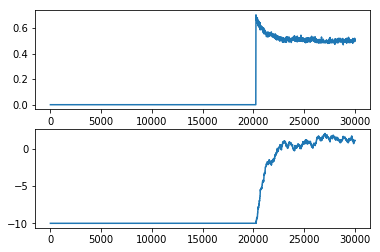

In [10]:
f, ax = plt.subplots(nrows=2)
for i in range(2):
    ax[i].plot(chain_ini[:,i])

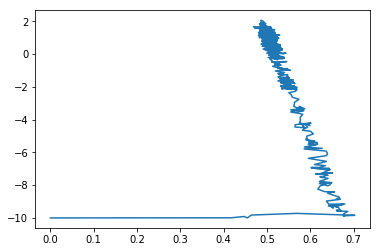

In [11]:
f, ax = plt.subplots(nrows=1)
ax.plot(chain_ini[:,0], chain_ini[:,1])

In [12]:
# Re-run the chain from the final position
chain, posterior = run_mcmc(ln_posterior, nsteps, theta0=chain_ini[-1,:], stepsize=stepsize, args=(x,y,dy))

Make histograms of the samples for each parameter. Should you include all of the samples? 

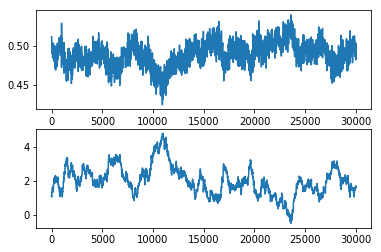

In [13]:
f, ax = plt.subplots(nrows=2)
for i in range(2):
    ax[i].plot(chain[:,i])

Compare the new chain with the previous one

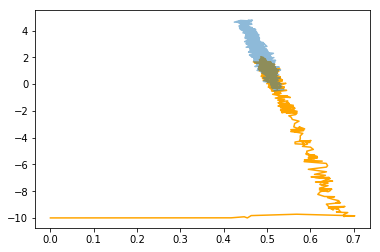

In [14]:
f, ax = plt.subplots(nrows=1)
ax.plot(chain_ini[:,0], chain_ini[:,1], color='orange')
ax.plot(chain[:,0], chain[:,1], alpha=0.5)

Visualize the distribution of the 2 parameters (and correlation)

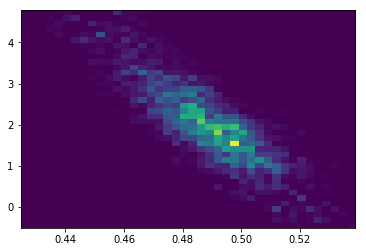

In [15]:
h2 = plt.hist2d(chain[:,0], chain[:,1], bins=40)

Report your constraints on the model parameters:      
This is the number for the abstract of the paper (or to report in the text of your thesis work) – the challenge is to figure out how to accurately summarize a multi-dimensional posterior (which is **the result** in Bayesianism) with a few numbers (which is what readers want to see as they skim the paper/thesis/report).

In [16]:
theta_best = chain.mean(0)
theta_std = chain.std(0)

print 'true intercept:%.1f'%theta_true[0] 
print 'true slope:%.2f'%theta_true[1] 
print 'intercept = %.2f +/- %.2f.'%(theta_best[1], theta_std[1])
print 'slope = %.2f +/- %.2f'%(theta_best[0], theta_std[0])

true intercept:2.0
true slope:0.50
intercept = 2.00 +/- 0.85.
slope = 0.49 +/- 0.02
